# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [7]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import panel as pn
from pathlib import Path
from dotenv import load_dotenv

# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')
import plotly.express as px
import hvplot.pandas

In [2]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX")
px.set_mapbox_access_token(mapbox_token)

# Import Data

In [3]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [4]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    housing_units = sfo_data.loc[:, ['housing_units']]
    housing_units_1K = housing_units.groupby('year').mean() / 1000
    housing_units_1K.plot(
    ylim=(350,400),
    kind='bar',
    title="Housing Units per Year (in '000s)")
    return housing_units_1K

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    rent_sales = sfo_data.loc[:, ['sale_price_sqr_foot','gross_rent']]
    avg_rent_sales = rent_sales.groupby('year').mean()
    avg_rent_sales['gross_rent'].plot(
    kind='line',
    title="Average Gross Rent in San Francisco")
    return avg_rent_sales

def average_sales_price():
    """Average Sales Price Per Year."""
    rent_sales = sfo_data.loc[:, ['sale_price_sqr_foot','gross_rent']]
    avg_rent_sales = rent_sales.groupby('year').mean()
    avg_rent_sales['sale_price_sqr_foot'].plot(
    kind='line',
    title="Average Sales Price/sqft in San Francisco")
    return avg_rent_sales
    
def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    nbhd_data = pd.DataFrame()
    nbhd_data = sfo_data.groupby(['year','neighborhood']).mean()
    nbhd_ppsf = nbhd_data.hvplot.bar(
    x='year',
    y='sale_price_sqr_foot',
    label='Neighborhood Data')
    return nbhd_ppsf

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    sale_prices_neighborhood = (
    sfo_data[["neighborhood", "sale_price_sqr_foot"]]
    .groupby("neighborhood")
    .mean()
    .sort_values("sale_price_sqr_foot",ascending=False))
    sale_prices_neighborhood.head(10).hvplot.bar(
    x="neighborhood", 
    y="sale_price_sqr_foot", rot=90).opts(
    yformatter="%.0f", 
    title="Top 10 Most Expensive Neighborhoods")
    return sale_prices_neighborhood


def parallel_coordinates():
    """Parallel Coordinates Plot."""
    nbhd_data = pd.DataFrame()
    nbhd_data = sfo_data.groupby(['year','neighborhood']).mean() 
    par_cor = px.parallel_coordinates(nbhd_data, color='housing_units')
    return par_cor

def parallel_categories():
    """Parallel Categories Plot."""
    nbhd_data = pd.DataFrame()
    nbhd_data = sfo_data.groupby(['year','neighborhood']).mean() 
    par_cat = px.parallel_categories(
    nbhd_data,
    dimensions=["housing_units", "sale_price_sqr_foot", "gross_rent"],
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
    labels={
        "housing_units": "Housing Units",
        "sale_price_sqr_foot": "Price p/sqf",
        "gross_rent": "Gross Rent",}
    )
    return par_cat

def neighborhood_map():
    """Neighborhood Map"""
    file_path = Path("Data/neighborhoods_coordinates.csv")
    df_neighborhood_locations = pd.read_csv(file_path, index_col='Neighborhood')
    neighborhood = (
    sfo_data
    .groupby("neighborhood")
    .mean()
    .sort_values("sale_price_sqr_foot",ascending=False)
    )
    nbhd_combined = pd.concat([df_neighborhood_locations,neighborhood],axis='columns',join='inner').reset_index()
    map_df_neighborhood = px.scatter_mapbox(
    nbhd_combined,
    lat="Lat",
    lon="Lon",
    color="index"
    )


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

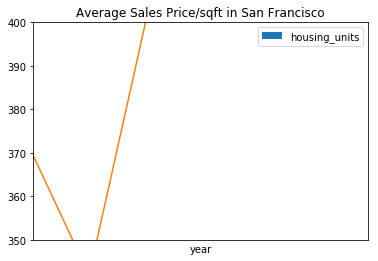

In [5]:
avg_nbhd_stats = pn.Column(
    "## Average Statistics by Neigborhood", 
    housing_units_per_year(), 
    average_gross_rent(),
    average_sales_price(),
    average_price_by_neighborhood(),
)

nbhd_mapped = pn.Column(
    "## Correlation of Population and Crime Plots",
    parallel_coordinates(),
    parallel_categories(),
    neighborhood_map(),
)

# Create tabs
nbhd_dashboard = pn.Tabs(
    ("Average Stats", avg_nbhd_stats), ("Neighbohood Maps", nbhd_mapped)
)

## Serve the Panel Dashboard

In [6]:
# Looks like crap, but it works...kind of.
nbhd_dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] DataFrame(DataFrame)
        [2] DataFrame(DataFrame)
        [3] DataFrame(DataFrame)
        [4] HoloViews(Bars)
    [1] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
        [3] Str(None)